# Predicting Heart Failure

In this project, we will build a K-Nearest Neighbor classifier to predict the likelihood of a patient having heart failure.

We will use a [Kaggle data set](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) that contains several features relevant to cardiovascular diseases.

## Exploring the data set

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
heart = pd.read_csv('files/heart.csv')
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
heart.shape

(918, 12)

Using the source of the data set, we have the following summary about our columns.

- `Age`: age of the patient [years]
- `Sex`: sex of the patient [M: Male, F: Female]
- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- `RestingBP`: resting blood pressure [mm Hg]
- `Cholesterol`: serum cholesterol [mm/dl]
- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
- `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- `HeartDisease`: output class [1: heart disease, 0: Normal]

In [4]:
heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

- Numerical variables: `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`
- Categorical variables: `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`
- Target variable: `HeartDisease`

In [5]:
# Number of missing values in the whole dataframe
heart.isna().sum().sum()

0

## Categorical variables

We start by looking at the categorical data using visualization to get a general understanding.

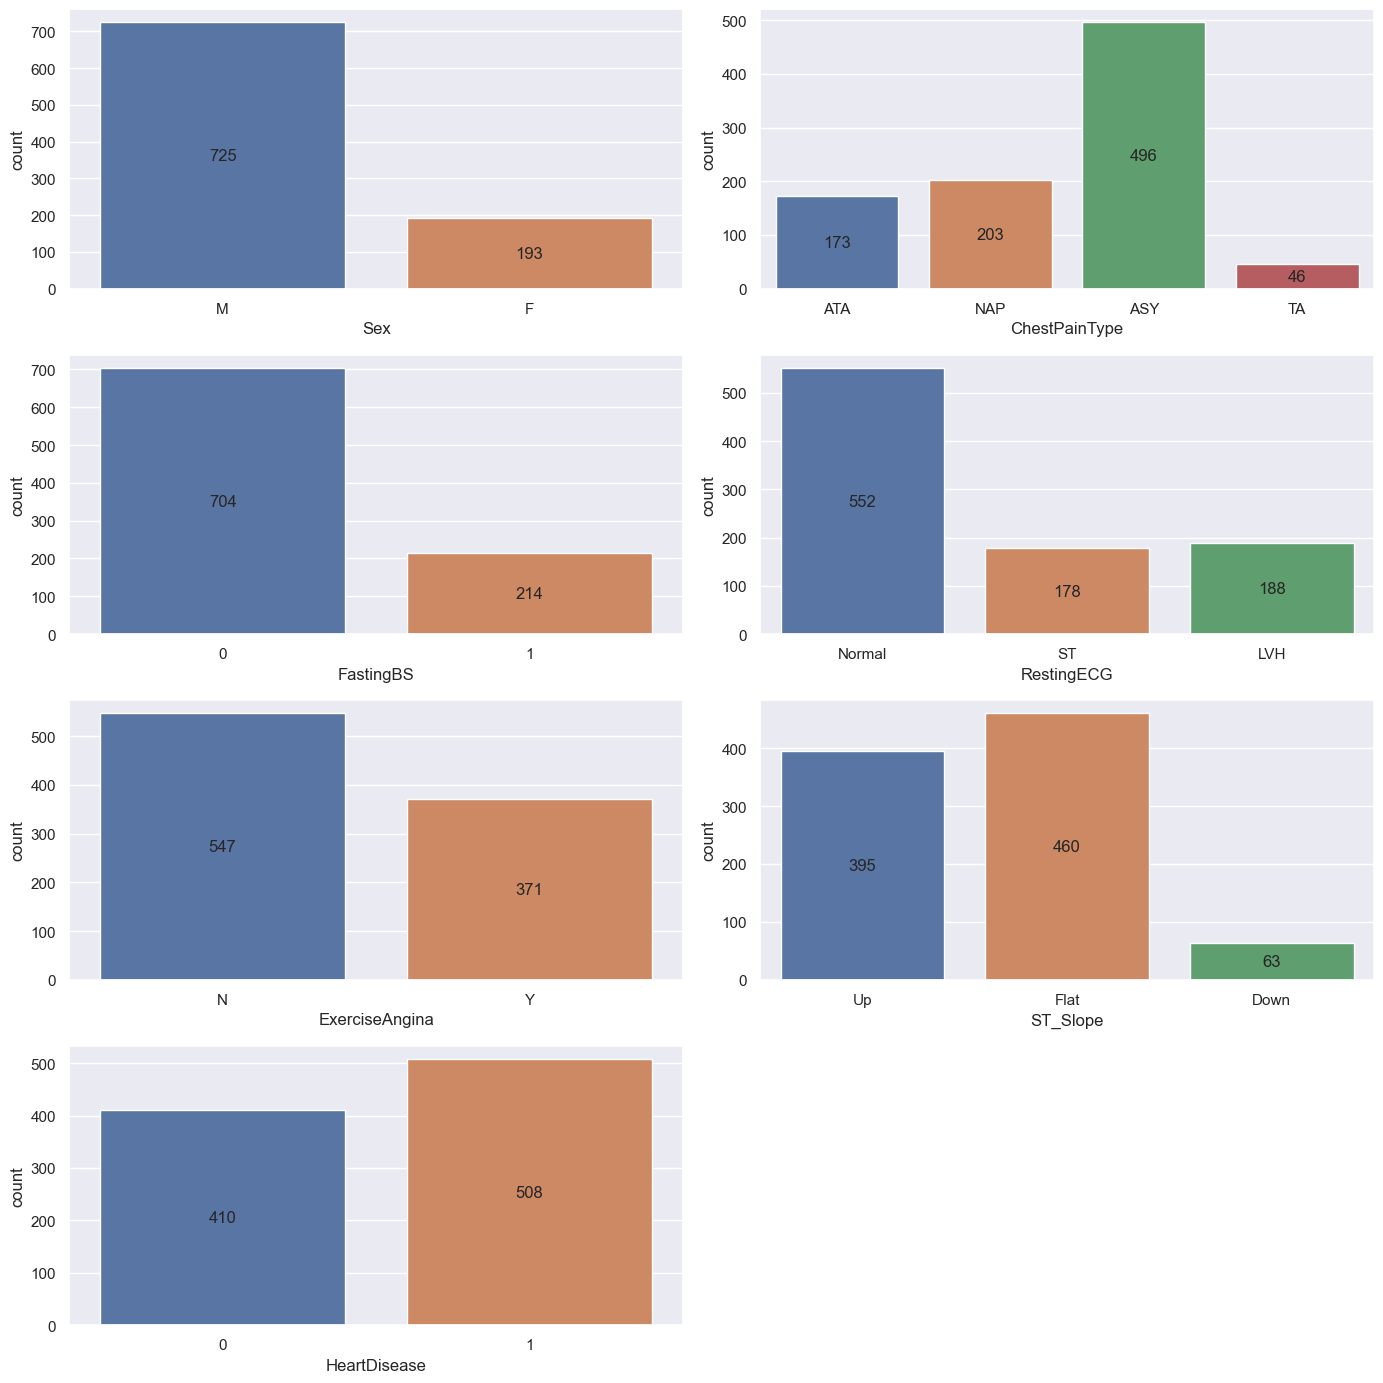

In [6]:
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

plt.figure(figsize=(14, 14))
sns.set_theme()

for i, c in enumerate(categorical):
    plt.subplot(4, 2, i+1)
    s = sns.countplot(x=heart[c])
    plt.bar_label(s.containers[0],
                  label_type='center')

plt.tight_layout()
plt.show()

- There is a lot more male patients than female patients. It's good to keep in mind that this can cause bias in our model.

- Among chest pain types, one is much more common than the others: ASY (Asymptomatic)

Next, we look at the distributions grouped by our target variable, `HeartDisease`

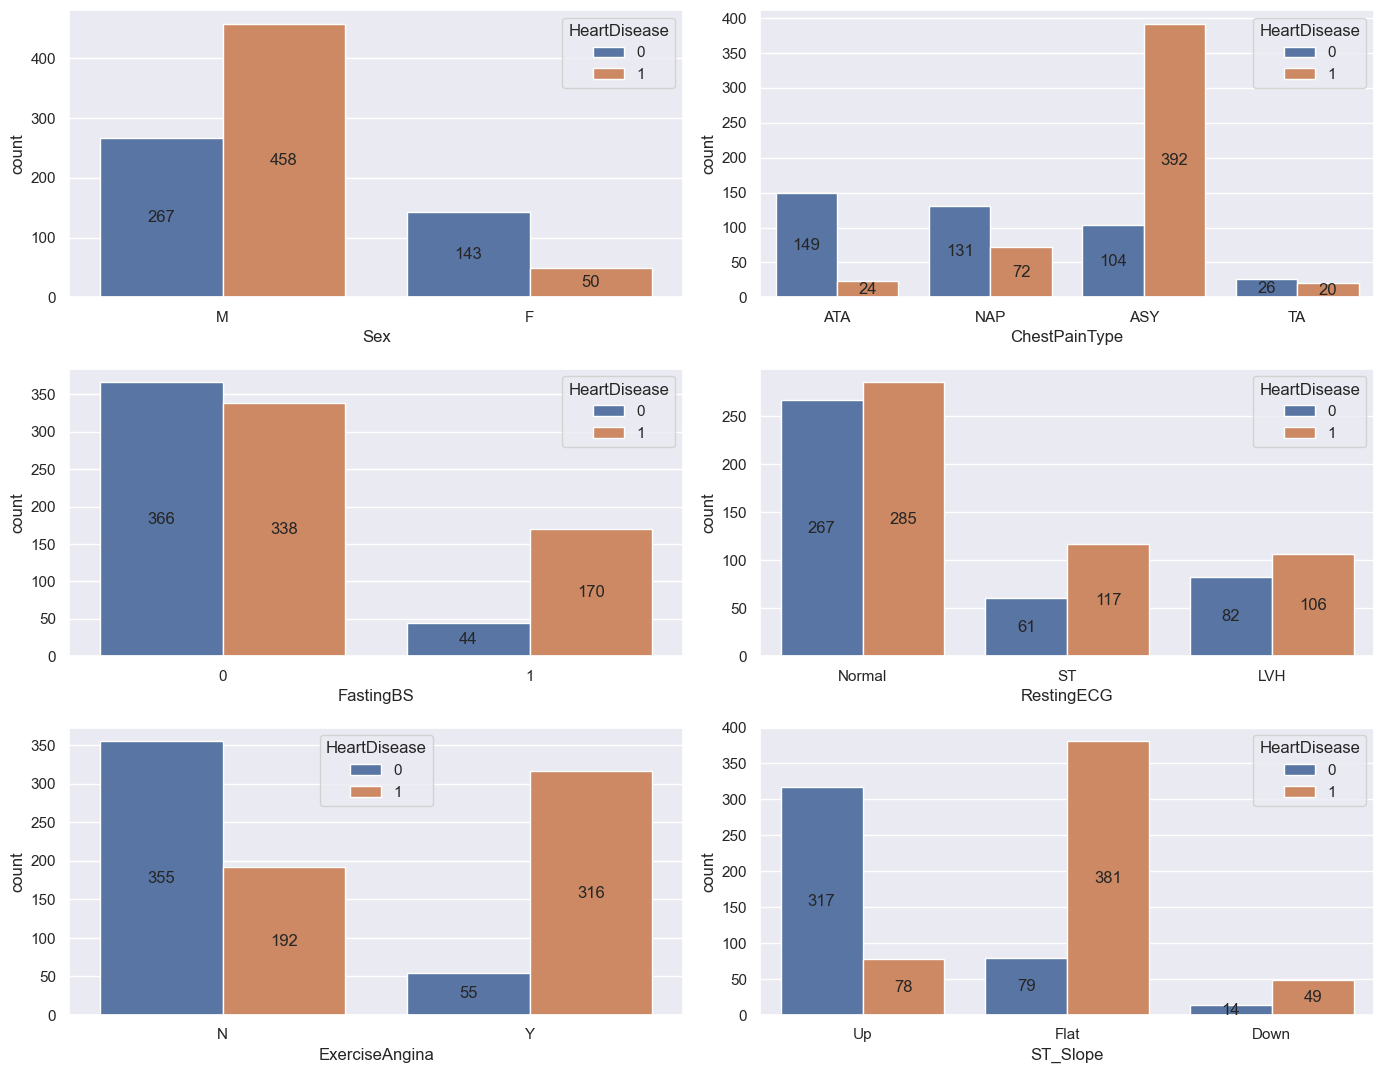

In [7]:
plt.figure(figsize=(14, 14))

for i, c in enumerate(categorical[:-1]):
    plt.subplot(4, 2, i+1)
    s = sns.countplot(x=heart[c],
                      hue=heart['HeartDisease'])
    for container in s.containers:
        plt.bar_label(container,
                      label_type='center')

plt.tight_layout()
plt.show()

- Among the patients with heart diseases in this data set, 458 of them are male, and only 50 of them are female. This is cause for concern relating to bias.

- An overwhelming majority of patients with asymptotic chest pain have heart diseases. However, since asymptotic chest pain consists of cases without specific patterns in chest pain, this is not a helpful correlation.

- When it comes to blood sugar, people with values greater than 120 mg/dl seem to be more prone to heart disease.

- The majority of people who have had exercise angina also have heart diseases.

- The majority of people with flat `ST_slope` have been diagnosed with heart disease while the majority with up `ST_slope` have not.

We will come bck to these observations when we are choosing features for our model.

## Numerical variables

In [8]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


`RestingBP` and `Cholesterol` seem to have a minimum of 0, which is not a possible value for either column. We will need to clean the faulty data points.

Let's see how many 0 values these columns have.

In [9]:
heart[heart['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [10]:
heart[heart['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


Since there is only a single observation where `RestingBP` is 0, we can just remove this row.

In [11]:
i = heart[heart['RestingBP'] == 0].index
heart.drop(i, inplace=True)

# Check if min has changed
heart['RestingBP'].describe()

count    917.000000
mean     132.540894
std       17.999749
min       80.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64

Dealing with the zeros in the `Cholesterol` column is more tricky; since 172 rows is not a small number of observations in our data set, we cannot just remove these rows.

Here, we choose to replace these 0 values with the median. Explicitly, we will consider the median of the `Cholesterol` values for patients with and without heart disease, and these values will replace the 0 entries in the `Cholesterol` column for each group of patients respectively.

In [12]:
# Heart disease mask
hd = heart['HeartDisease'] == 1

# Find the medians for each group and replacing
median1 = heart.loc[hd, 'Cholesterol'].median()
median2 = heart.loc[~hd, 'Cholesterol'].median()

heart.loc[hd, 'Cholesterol'] = heart.loc[hd, 'Cholesterol'].replace(to_replace = 0, value = median1)
heart.loc[~hd, 'Cholesterol'] = heart.loc[~hd, 'Cholesterol'].replace(to_replace = 0, value = median2)

# Check if min has changed
heart['Cholesterol'].describe()

count    917.000000
mean     239.700109
std       54.352727
min       85.000000
25%      214.000000
50%      225.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

Before moving on with feature selection, let's take a general look at how the numerical variables interact with the target variable.

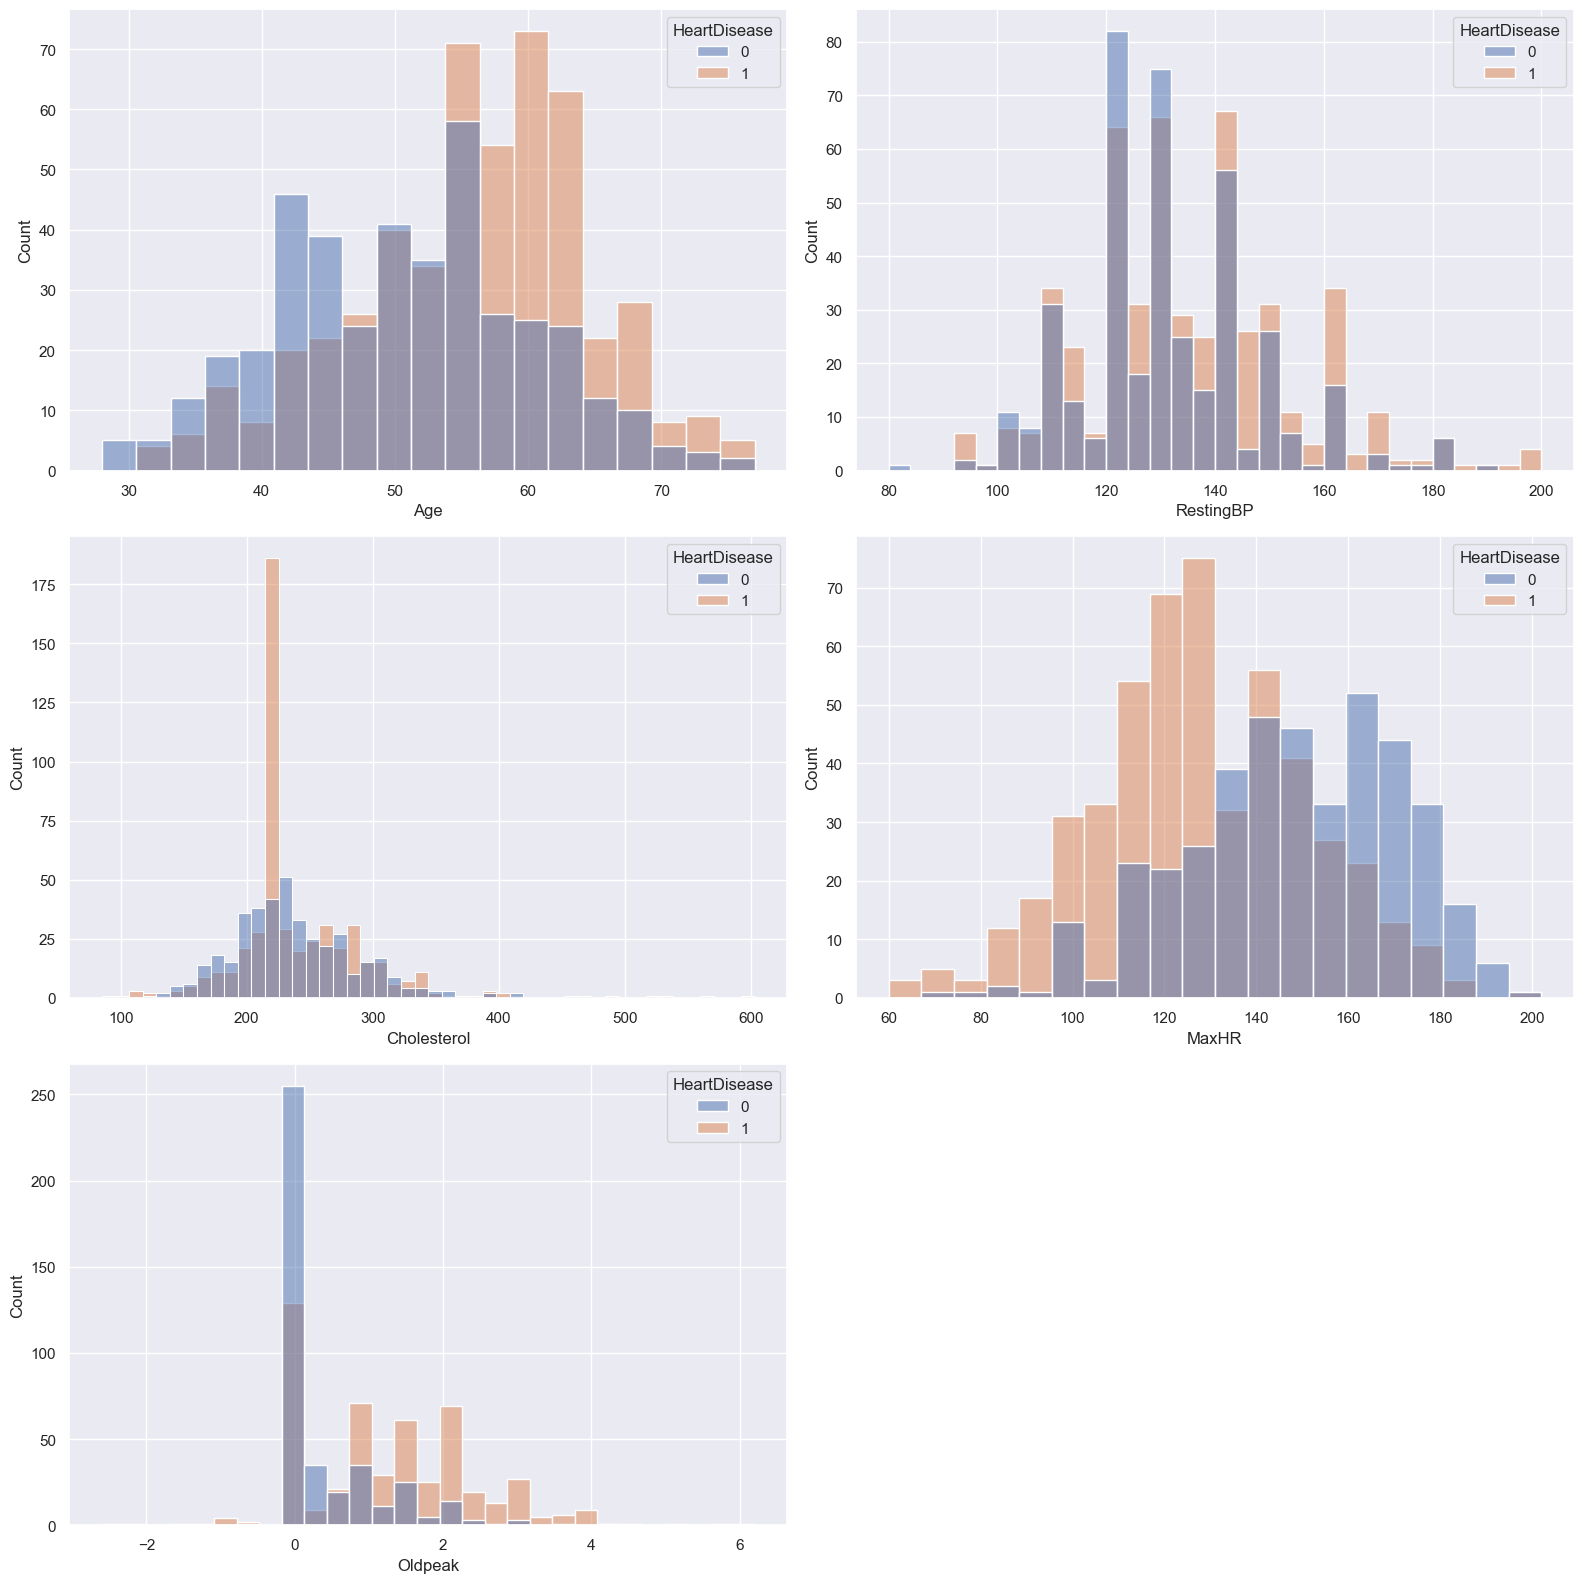

In [13]:
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

plt.figure(figsize=(16, 16))

for i, c in enumerate(numerical):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=heart[c],
                 hue=heart['HeartDisease'])

plt.tight_layout()
plt.show()

`Age`, `MaxHR` and `Oldpeak` seem to have some correlations with having a heart disease.

## Feature Selection

Our observations above suggest the following features are closely related to having a heart disease:

- `Age`
- `Sex`
- `FastingBS`
- `ExerciseAngina`
- `ST_Slope`
- `Age`
- `MaxHR`
- `OldPeak`

Now we will consider what Pearson's R coefficients can tell us. We start with getting dummy variables for categorical features.

In [14]:
heart = pd.get_dummies(data=heart, drop_first=True)
heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


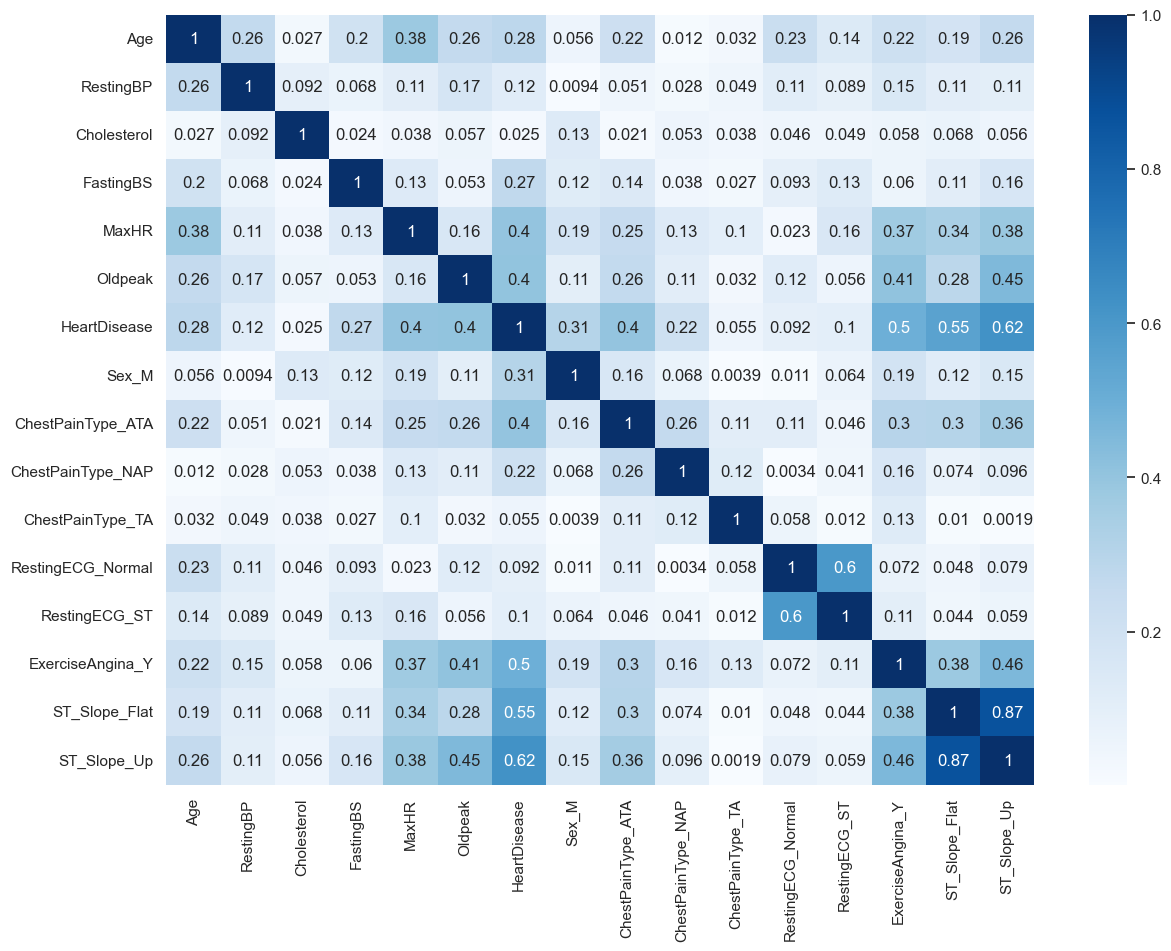

In [15]:
# Sign of corr is not important for our purposes
correlations = heart.corr().abs()

plt.figure(figsize=(14, 10))
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.show()

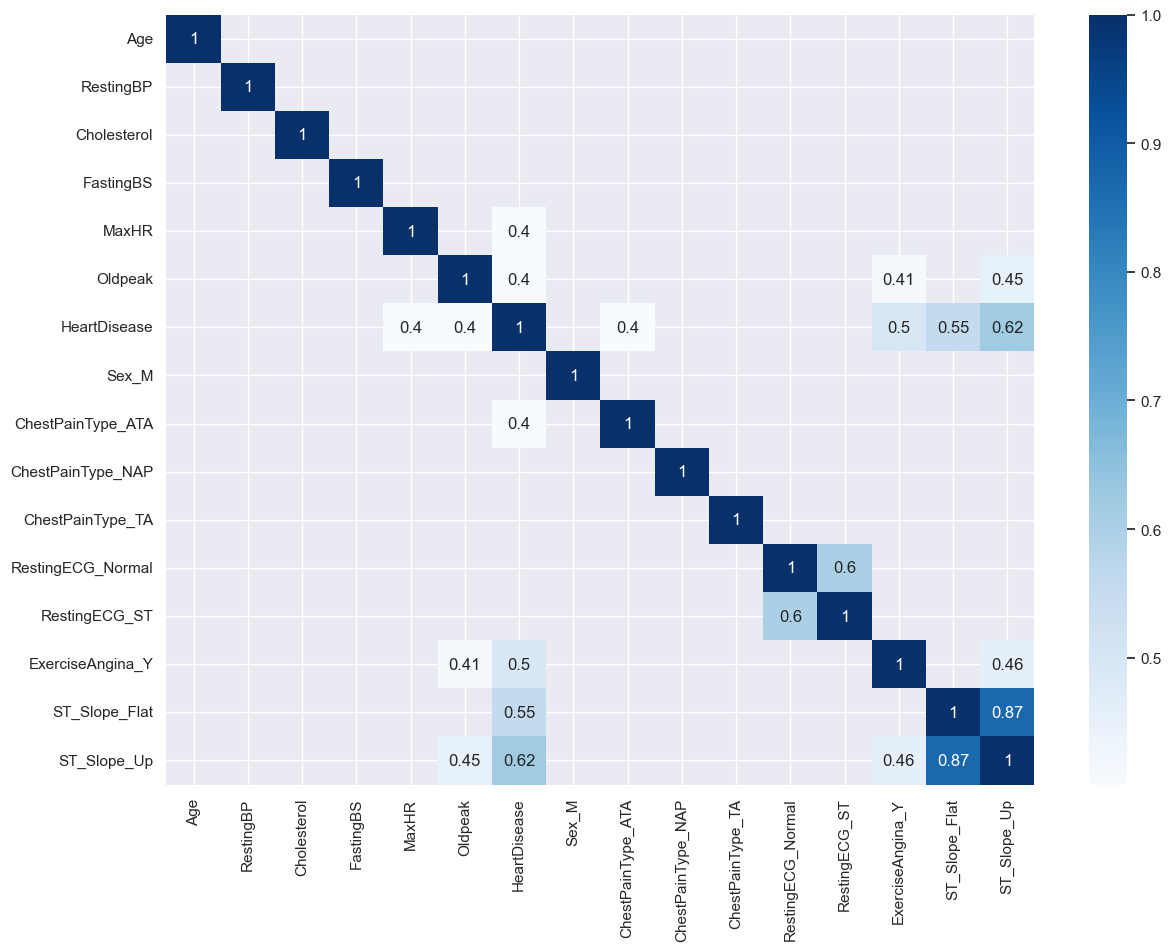

In [16]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlations[correlations > 0.4],
            annot=True, cmap='Blues')
plt.show()

The following columns are strongly correlated with our target: `ST_Slope_Flat`, `ST_Slope_Up`, `ExerciseAngina_Y`. This agrees with our observations from visualizations.

Even though they are not high on the list here, using our visualizations from before, we will consider `Oldpeak`, `Age` and `Sex_M` as well.

## Building a classifier

We will start with building classifiers using a single feature and analyzing their performances. Afterwards, we'll build one using all features we have chosen above and compare performances of our options.

<!-- We start by splitting our data set into a training set (60%), a validation set (20%) and a test set (20%). -->
We start by splitting our data set into a training set (85%) and a test set (15%).

In [17]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [18]:
X = heart.drop(['HeartDisease'], axis=1)
y = heart['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

features = ['Age', 'Sex_M', 'Oldpeak', 'ST_Slope_Flat', 'ST_Slope_Up', 'ExerciseAngina_Y']

accuracies = {}
for f in features:
    knn = KNeighborsClassifier(5)
    knn.fit(X_train[[f]], y_train)
    accuracies[f] = knn.score(X_test[[f]], y_test)

for f, acc in accuracies.items():
    print("Accuracy of model using {}: {:.2f}".format(f, acc*100))

Accuracy of model using Age: 60.87
Accuracy of model using Sex_M: 68.12
Accuracy of model using Oldpeak: 68.12
Accuracy of model using ST_Slope_Flat: 75.36
Accuracy of model using ST_Slope_Up: 78.26
Accuracy of model using ExerciseAngina_Y: 61.59


The best scores with a single feature come from `ST_Slope_Up` and `ST_Slope_Flat` which is not surprising considering the plots we saw before.

We have only tried $k=5$ for the number of neighbors for now but we will come back to hyperparameter optimization later on.

Next we build a classifier with all features we have selected. First we will normalize the data.

In [19]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

knn = KNeighborsClassifier(5)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_test_scaled, y_test)

print("Accuracy of model using all features: {:.2f}".format(accuracy*100))

Accuracy of model using all features: 80.43


This is a little bit better than the results with a single feature which is promising.

Let's see how we can optimize the parameters in our classifiers. We will use the following values in a grid search:

- Number of neighbors, k, in the range of integers from 1 to 25

- Distance metrics `minkowski` vs `manhattan`

- Weights assigned to each neighbor pt, namely `uniform` vs `distance`, with `p`value in the range of integers from 1 to 10

In [20]:
grid_param = {'n_neighbors': range(1, 26),
              'metric': ['minkowski', 'manhattan'],
              'weights': ['uniform', 'distance'],
              'p': range(1, 11)}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_param, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

print("Best score: {:.2f}".format(knn_grid.best_score_ * 100))
print("with parameters: {}".format(knn_grid.best_params_))

Best score: 85.36
with parameters: {'metric': 'minkowski', 'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}


## Conclusion

We have analyzed our data set to select features and we have built a classifier that has an accuracy score of about 85%.

One thing to keep in mind is how unevenly the data set is distributed between male and female patients. This imbalance can impact our model; if the model is trained on a data set skewed towards male patients, then one can expect it to do well on a similarly skewed test set.

Just to illustrate this in our data set, we conclude our analysis with a relevant visualization.

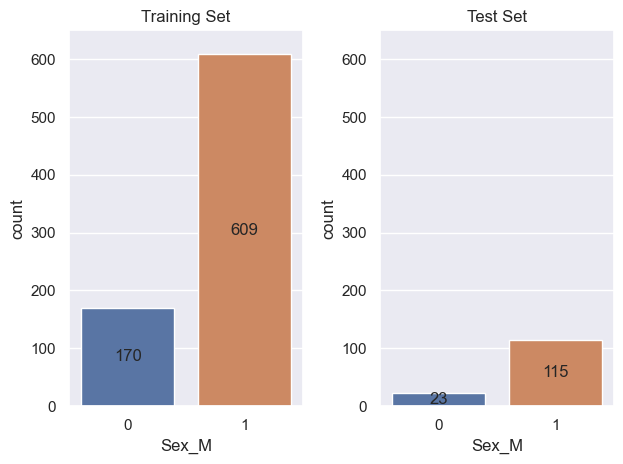

In [21]:
plt.figure()

plt.subplot(1, 2, 1)
s = sns.countplot(X_train['Sex_M'])
plt.bar_label(s.containers[0],
              label_type='center')
plt.ylim([0, 650])
plt.title("Training Set")

plt.subplot(1, 2, 2)
s = sns.countplot(X_test['Sex_M'])
plt.bar_label(s.containers[0],
              label_type='center')
plt.ylim([0, 650])
plt.title("Test Set")

plt.tight_layout()
plt.show()